# Gesture Recognition
In this project we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

In [1]:
# Importing the necessary libraries

import numpy as np
import os
import pandas as pd
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
#Reinstates Pandas Plotting Converters to Use for Graphs
pd.plotting.register_matplotlib_converters()


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
# tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
data_loc = "C:/Users\King/Desktop/Project_data"
train_doc = np.random.permutation(open(data_loc + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_loc+'/val.csv').readlines())
batch_size = 8

#### Note : Initially tried with batch size 16, 32, 64 they didnt seem productive and for batches for sizes 32 and 64 had too much RAM consumption, Hence for Conv3D models 8 and 16 were providing good results 


## Generator
This is one of the most important part of the code. In the generator, We are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(100,100))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        remaining = len(t) % batch_size
        print(remaining)
        if remaining != 0:
            batch_data = np.zeros((remaining,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*remaining)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(100,100))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255                    
                batch_labels[folder, int(t[folder + (batch*remaining)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [5]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'

In [6]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [7]:
testGen = generator(train_path,train_doc,batch_size)

In [8]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8


In [9]:
batch_data.shape

(8, 15, 100, 100, 3)

In [10]:
inputShape = batch_data[0].shape
inputShape

(15, 100, 100, 3)

#### Checking the input images

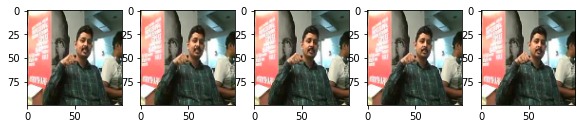

In [11]:
plt.figure(figsize=(20,10))
for i in range(1,6):
  ax = plt.subplot(2,10, i)
  plt.imshow(batch_data[2][i-1])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here we make the model using different functionalities that Keras provides. We use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. So we design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.applications import mobilenet #for transfer learning
from tensorflow.keras import backend as K

In [14]:
K.clear_session()

## Model 1 : Using Conv3D

In [15]:
Input_shape = inputShape
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))


model.add(Conv3D(32, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))



model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [16]:
optimiser =Adam(0.001) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 50, 50, 16)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 7, 50, 50, 32)     0         
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
steps_per_epoch

83

Let us now fit the model. This will start training the model and with the help of the checkpoints, We'll be able to save the model at the end of each epoch.

In [21]:
history_basic = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8
Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 2.0773 - categorical_accuracy: 0.2489Source path =  C:/Users\King/Desktop/Project_data/val ; batch size = 8
4
83/83 [==============================] - 235s 3s/step - loss: 2.0773 - categorical_accuracy: 0.2489 - val_loss: 1.7226 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - 235s 3s/step - loss: 1.4547 - categorical_accuracy: 0.4404 - val_loss: 1.3047 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - 235s 3s/step - loss: 1.1378 - categorical_accuracy: 0.5475 - val_loss: 0.9967 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - 235s 3s/step - loss: 0.8744 - categorical_accuracy: 0.6682 - val_loss: 0.8744 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 5/10
83/83 [==============================

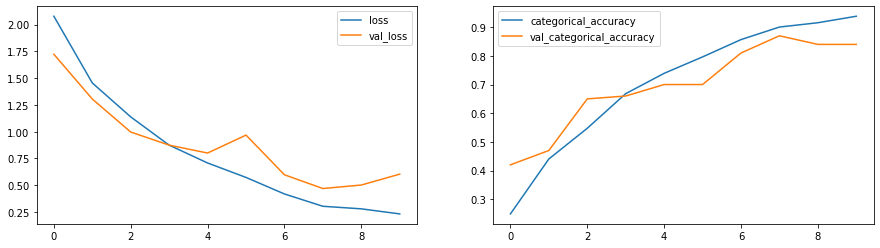

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
plot(history_basic)

#### Note:

__With 10 epoch our training accuracy and validation accuracy came out to be good.__

So now we will increase number of epochs and add some more dropout and regularization to overcome overfitting.

## Model 2 : Using Conv3D

In [23]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [24]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)



Input_shape = inputShape
model_2 = Sequential()
model_2.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))


model_2.add(Conv3D(32, (3, 3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv3D(64, (3, 3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))



model_2.add(Flatten())
model_2.add(Dense(64,kernel_regularizer=l2(0.01)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(128,kernel_regularizer=l2(0.01)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(5))
model_2.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_7 (Activation)   (None, 7, 50, 50, 32)

In [25]:
# Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)    

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.7913 - categorical_accuracy: 0.1916Source path =  C:/Users\King/Desktop/Project_data/val ; batch size = 8
4

Epoch 00001: val_loss improved from inf to 2.20009, saving model to Model_2_2022-01-0519_21_30.507305\model-00001-2.79129-0.19155-2.20009-0.23000.h5
83/83 [==============================] - 238s 3s/step - loss: 2.7913 - categorical_accuracy: 0.1916 - val_loss: 2.2001 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.9985 - categorical_accuracy: 0.23984

Epoch 00002: val_loss improved from 2.20009 to 1.83921, saving model to Model_2_2022-01-0519_21_30.507305\model-00002-1.99853-0.23982-1.83921-0.39000.h5
83/83 [==============================] - 236s 3s/step - loss: 1.9985 - categorical_accuracy: 0.2398 - val_loss: 1.8392 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoc

Epoch 17/20
83/83 [==============================] - ETA: 0s - loss: 0.5607 - categorical_accuracy: 0.86274

Epoch 00017: val_loss did not improve from 0.58131

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 [==============================] - 236s 3s/step - loss: 0.5607 - categorical_accuracy: 0.8627 - val_loss: 0.7101 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 18/20
83/83 [==============================] - ETA: 0s - loss: 0.5089 - categorical_accuracy: 0.89594

Epoch 00018: val_loss improved from 0.58131 to 0.52708, saving model to Model_2_2022-01-0519_21_30.507305\model-00018-0.50886-0.89593-0.52708-0.87000.h5
83/83 [==============================] - 237s 3s/step - loss: 0.5089 - categorical_accuracy: 0.8959 - val_loss: 0.5271 - val_categorical_accuracy: 0.8700 - lr: 5.0000e-04
Epoch 19/20
83/83 [==============================] - ETA: 0s - loss: 0.4410 - categorical_accuracy: 0.91704

Epoch 00019: val_loss did not improve from 0.52708

<function matplotlib.pyplot.show(close=None, block=None)>

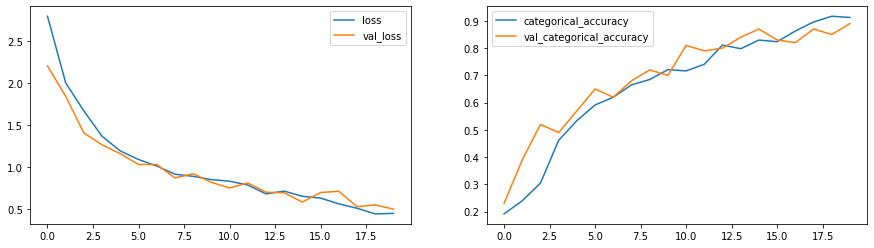

In [26]:
plot(history_2)
plt.show

#### Note:

_We did observe an improvement in accuracy for both training and validation._

But lets try to make it more steady.

## Model 3 : Using Conv3D

##### Lets have a Model with more dropout percentage

In [27]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [28]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)


Input_shape = inputShape
model_3 = Sequential()
model_3.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model_3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.3))


model_3.add(Conv3D(32, (3, 3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.3))

model_3.add(Conv3D(64, (3, 3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.2))



model_3.add(Flatten())
model_3.add(Dense(64,kernel_regularizer=l2(0.01)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(128,kernel_regularizer=l2(0.01)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.4))

model_3.add(Dense(5))
model_3.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 25
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 7, 50, 50, 32)

In [29]:
# Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_3 = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)  

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 2.8553 - categorical_accuracy: 0.2187Source path =  C:/Users\King/Desktop/Project_data/val ; batch size = 8
4

Epoch 00001: val_loss improved from inf to 2.28322, saving model to Model_3_2022-01-0520_41_07.368160\model-00001-2.85534-0.21870-2.28322-0.23000.h5
83/83 [==============================] - 369s 4s/step - loss: 2.8553 - categorical_accuracy: 0.2187 - val_loss: 2.2832 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 2.0610 - categorical_accuracy: 0.19164

Epoch 00002: val_loss improved from 2.28322 to 1.90082, saving model to Model_3_2022-01-0520_41_07.368160\model-00002-2.06097-0.19155-1.90082-0.32000.h5
83/83 [==============================] - 499s 6s/step - loss: 2.0610 - categorical_accuracy: 0.1916 - val_loss: 1.9008 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoc

Epoch 17/25
83/83 [==============================] - ETA: 0s - loss: 0.7279 - categorical_accuracy: 0.77684

Epoch 00017: val_loss did not improve from 0.73907
83/83 [==============================] - 262s 3s/step - loss: 0.7279 - categorical_accuracy: 0.7768 - val_loss: 0.8374 - val_categorical_accuracy: 0.7600 - lr: 5.0000e-04
Epoch 18/25
83/83 [==============================] - ETA: 0s - loss: 0.6077 - categorical_accuracy: 0.82964

Epoch 00018: val_loss improved from 0.73907 to 0.67288, saving model to Model_3_2022-01-0520_41_07.368160\model-00018-0.60774-0.82956-0.67288-0.84000.h5
83/83 [==============================] - 230s 3s/step - loss: 0.6077 - categorical_accuracy: 0.8296 - val_loss: 0.6729 - val_categorical_accuracy: 0.8400 - lr: 5.0000e-04
Epoch 19/25
83/83 [==============================] - ETA: 0s - loss: 0.5583 - categorical_accuracy: 0.86274

Epoch 00019: val_loss did not improve from 0.67288
83/83 [==============================] - 334s 4s/step - loss: 0.5583 - categ

<function matplotlib.pyplot.show(close=None, block=None)>

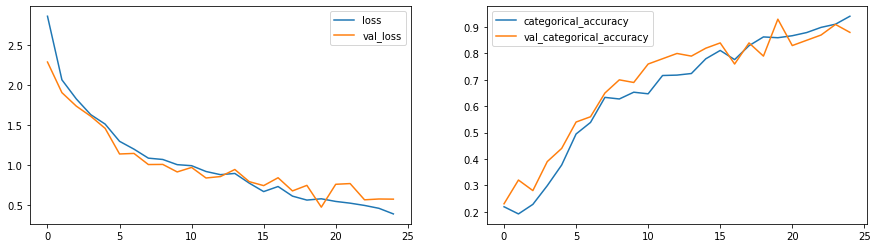

In [30]:
plot(history_3)
plt.show

**Observation:**
    
- Loss and Val loss looks good.
- But there is alot of fluctuation on accuracy graph.
- So in the next model we will increase the number of epochs and give more time to model for learning.

## Model 4 : Using Conv3D

In [31]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [32]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)


Input_shape = inputShape
model_3_1 = Sequential()
model_3_1.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model_3_1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.3))


model_3_1.add(Conv3D(32, (3, 3,3), padding='same'))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.3))

model_3_1.add(Conv3D(64, (3, 3,3), padding='same'))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.2))



model_3_1.add(Flatten())
model_3_1.add(Dense(64,kernel_regularizer=l2(0.01)))
model_3_1.add(Activation('relu'))
model_3_1.add(Dropout(0.4))
model_3_1.add(Dense(128,kernel_regularizer=l2(0.01)))
model_3_1.add(Activation('relu'))
model_3_1.add(Dropout(0.4))

model_3_1.add(Dense(5))
model_3_1.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_3_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3_1.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 40
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_18 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_19 (Activation)  (None, 7, 50, 50, 32)

In [33]:
# Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_3_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_3_1 = model_3_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)    

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 8
Epoch 1/40
83/83 [==============================] - ETA: 0s - loss: 2.7945 - categorical_accuracy: 0.2278Source path =  C:/Users\King/Desktop/Project_data/val ; batch size = 8
4

Epoch 00001: val_loss improved from inf to 2.22573, saving model to Model_3_1_2022-01-0523_31_18.570264\model-00001-2.79454-0.22775-2.22573-0.41000.h5
83/83 [==============================] - 377s 5s/step - loss: 2.7945 - categorical_accuracy: 0.2278 - val_loss: 2.2257 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/40
83/83 [==============================] - ETA: 0s - loss: 1.8909 - categorical_accuracy: 0.35604

Epoch 00002: val_loss improved from 2.22573 to 1.48157, saving model to Model_3_1_2022-01-0523_31_18.570264\model-00002-1.89088-0.35596-1.48157-0.53000.h5
83/83 [==============================] - 384s 5s/step - loss: 1.8909 - categorical_accuracy: 0.3560 - val_loss: 1.4816 - val_categorical_accuracy: 0.5300 - lr: 0.0010


Epoch 17/40
83/83 [==============================] - ETA: 0s - loss: 0.6698 - categorical_accuracy: 0.85074

Epoch 00017: val_loss improved from 0.73453 to 0.57610, saving model to Model_3_1_2022-01-0523_31_18.570264\model-00017-0.66981-0.85068-0.57610-0.86000.h5
83/83 [==============================] - 230s 3s/step - loss: 0.6698 - categorical_accuracy: 0.8507 - val_loss: 0.5761 - val_categorical_accuracy: 0.8600 - lr: 5.0000e-04
Epoch 18/40
83/83 [==============================] - ETA: 0s - loss: 0.6227 - categorical_accuracy: 0.86734

Epoch 00018: val_loss did not improve from 0.57610
83/83 [==============================] - 230s 3s/step - loss: 0.6227 - categorical_accuracy: 0.8673 - val_loss: 0.7251 - val_categorical_accuracy: 0.8200 - lr: 5.0000e-04
Epoch 19/40
83/83 [==============================] - ETA: 0s - loss: 0.5712 - categorical_accuracy: 0.88694

Epoch 00019: val_loss improved from 0.57610 to 0.53569, saving model to Model_3_1_2022-01-0523_31_18.570264\model-00019-0.571

<function matplotlib.pyplot.show(close=None, block=None)>

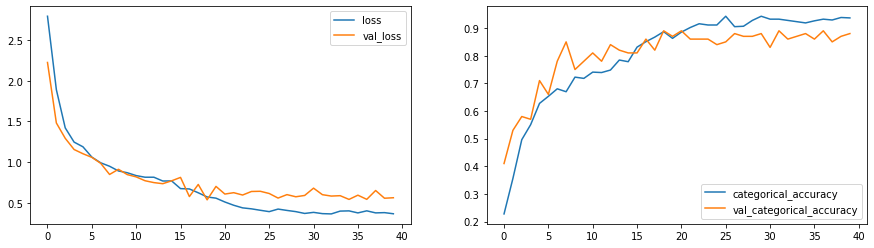

In [34]:
plot(history_3_1)
plt.show

**Observation:**
- Model is fairly good.
- We have least number of fluctuation in the end.
- So far this is the best model using Conv3D.

#### Now Lets try with Conv2D + RNN models, We will use Tansfer Learnging + GRU

## Model 5 : Using Conv2D + RNN  (Transfer Learning + GRU base model)

In [35]:
batch_size = 16

In [36]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  C:/Users\King/Desktop/Project_data/train ; batch size = 16


(15, 100, 100, 3)

In [37]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
model_name = 'Model_3_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 1 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_1 = Sequential()
model_gru_1.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_1.add(TimeDistributed(BatchNormalization()))
model_gru_1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_1.add(TimeDistributed(Flatten()))

model_gru_1.add(GRU(64))
model_gru_1.add(Dropout(0.3))

model_gru_1.add(Dense(64,activation='relu'))
model_gru_1.add(Dropout(0.3))

model_gru_1.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_1.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=10
model_gru_1=model_gru_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)               

<function matplotlib.pyplot.show(close=None, block=None)>

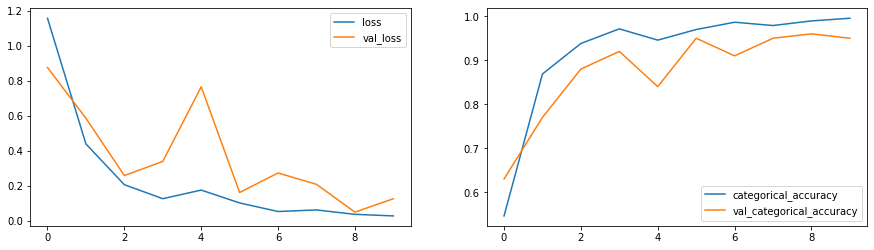

In [40]:
plot(model_gru_1)
plt.show

**Observations:**
    
- Getting approx 95 training accuracy and 92 validation accuracy.
- Will experiment by removing the dropout in the next model.

## Model 6 : Using Conv2D + RNN  (Transfer Learning + GRU base model)

##### Reduced dropout and checking again for 5 epoch

In [41]:
model_name = 'Model_TL_GRU_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 1 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_2 = Sequential()
model_gru_2.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_2.add(TimeDistributed(BatchNormalization()))
model_gru_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_2.add(TimeDistributed(Flatten()))

model_gru_2.add(GRU(64))
model_gru_2.add(Dropout(0.2))

model_gru_2.add(Dense(64,activation='relu'))

model_gru_2.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_2.summary())

# Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=5
model_gru_2=model_gru_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)               

<function matplotlib.pyplot.show(close=None, block=None)>

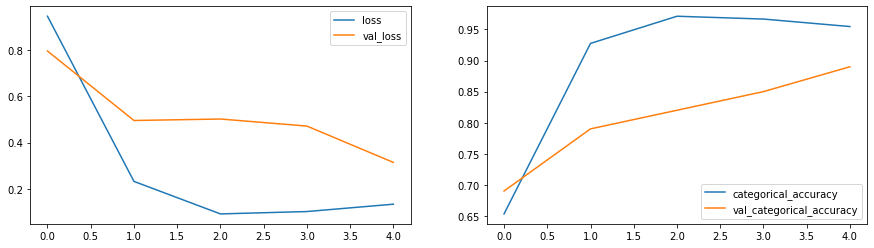

In [42]:
plot(model_gru_2)
plt.show

**Observations:**
    
- Not getting the clear picture by using 5 epochs. 
- But model looks ok.

## Model 7 : Using Conv2D + RNN  (Transfer Learning + GRU base model)

##### In this model we are using model no 6 and increasing the number of epochs. Because we cann't predict using 5 epochs. So. lets re-observe after increasing the epochs from 5 to 20.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

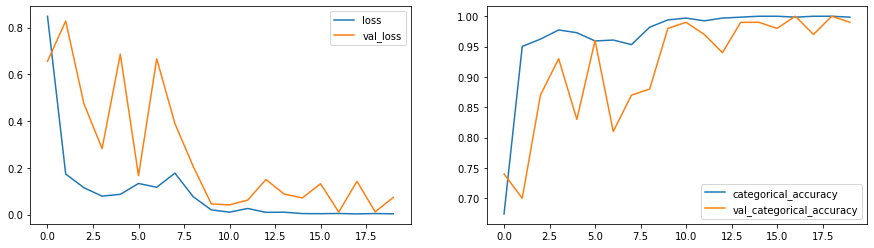

In [43]:
model_name = 'Model_TL_GRU_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 3 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_3 = Sequential()
model_gru_3.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_3.add(TimeDistributed(BatchNormalization()))
model_gru_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_3.add(TimeDistributed(Flatten()))

model_gru_3.add(GRU(64))
model_gru_3.add(Dropout(0.2))

model_gru_3.add(Dense(64,activation='relu'))

model_gru_3.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_3.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=20
model_gru_3=model_gru_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_3)

<function matplotlib.pyplot.show(close=None, block=None)>

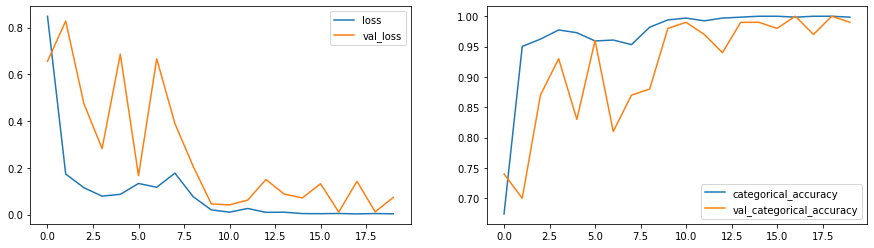

In [44]:
plot(model_gru_3)
plt.show

**Observations:**
    
- This model seems to be the best yet.
- Taining Accuracy lies between: 95-98
- Validation Accuracy lies between: 92-95

## Model 8 : Using Conv2D + RNN  (Transfer Learning + GRU base model)

##### We will try to reduce the training and validation gap a little more.

In [45]:
model_name = 'Model_TL_GRU_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 4 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_5 = Sequential()
model_gru_5.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_5.add(TimeDistributed(BatchNormalization()))
model_gru_5.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_5.add(TimeDistributed(Flatten()))

model_gru_5.add(GRU(64))
model_gru_5.add(Dropout(0.5))

model_gru_5.add(Dense(64,activation='relu'))
model_gru_5.add(Dropout(0.5))

model_gru_5.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_5.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=20
model_gru_5=model_gru_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)               

Epoch 13/20
42/42 [==============================] - ETA: 0s - loss: 0.0745 - categorical_accuracy: 0.99104

Epoch 00013: val_loss did not improve from 0.02121
42/42 [==============================] - 220s 5s/step - loss: 0.0745 - categorical_accuracy: 0.9910 - val_loss: 0.1949 - val_categorical_accuracy: 0.9700 - lr: 2.5000e-04
Epoch 14/20
42/42 [==============================] - ETA: 0s - loss: 0.0419 - categorical_accuracy: 0.99254
4

Epoch 00014: val_loss did not improve from 0.02121

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
42/42 [==============================] - 219s 5s/step - loss: 0.0419 - categorical_accuracy: 0.9925 - val_loss: 0.1158 - val_categorical_accuracy: 0.9600 - lr: 2.5000e-04
Epoch 15/20
42/42 [==============================] - ETA: 0s - loss: 0.0428 - categorical_accuracy: 0.98944

Epoch 00015: val_loss did not improve from 0.02121
42/42 [==============================] - 219s 5s/step - loss: 0.0428 - categorical_accuracy: 0.

<function matplotlib.pyplot.show(close=None, block=None)>

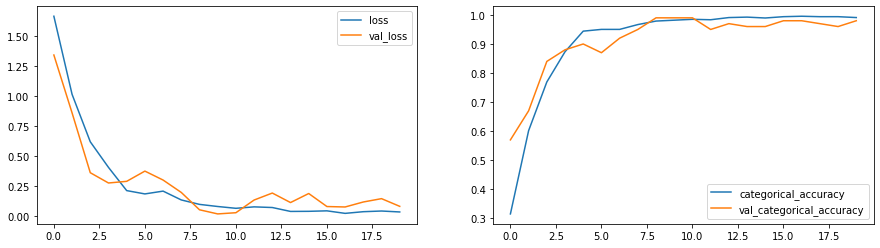

In [46]:
plot(model_gru_5)
plt.show

**Observations:**
    
- This model also looks good but not better than model 7. 
- Training Accuracy lies between: 94-97
- Validation Accuracy lies between: 88-92

# Interpretation : 

## Out of all the Conv 3D and Conv 2D + RNN models we can proceed with Model 7 as it attained higher accuracy and stability 

<function matplotlib.pyplot.show(close=None, block=None)>

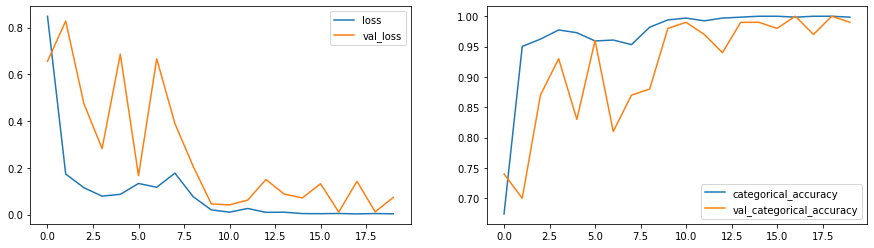

In [47]:
# Viewing Model 7

plot(model_gru_3)
plt.show